In [11]:
import logging
import os
from itertools import combinations
from pathlib import Path
from typing import List, Optional, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import polars as pl
import seaborn as sns
from IPython.display import display
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import resample, resample_poly
from scipy.stats.qmc import discrepancy, Sobol
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler


os.chdir("/root/py_projects/aihiii")

import src.utils.json_util as json_util
from src._StandardNames import StandardNames
from src.evaluate._Data import Data
from src.utils.CfCFilter import CfCFilter
from src.utils.custom_log import init_logger
from src.utils.ParquetHandler import ParquetHandler
from src.utils.set_rcparams import set_rcparams

set_rcparams()

LOG: logging.Logger = logging.getLogger(__name__)
STR: StandardNames = StandardNames()
D_DIR: Path = Path("data") / "doe" / "doe_sobol_20240705_194200"
EXP_DIR: Path = Path("experiments") / "models" / "CNN" / "Sobol_Size"
init_logger(log_lvl=logging.INFO)
LOG.info("Working directory: %s", os.getcwd())
LOG.info("D_DIR directory: %s - Exist %s", D_DIR, D_DIR.is_dir())
LOG.info("EXP_DIR directory: %s - Exist %s", EXP_DIR, EXP_DIR.is_dir())

WIDTH: float = 448.13095 / 72 - 0.2

2025-01-02 20:08:36,717     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2025-01-02 20:08:36,726     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle
2025-01-02 20:08:36,728     INFO  MainProcess  MainThread Working directory: /root/py_projects/aihiii
2025-01-02 20:08:36,729     INFO  MainProcess  MainThread D_DIR directory: data/doe/doe_sobol_20240705_194200 - Exist True
2025-01-02 20:08:36,730     INFO  MainProcess  MainThread EXP_DIR directory: experiments/models/CNN/Sobol_Size - Exist True


In [2]:
FIG_DIR: Path = Path() / "reports" / "figures"
FIG_DIR /= "characterize_50th"
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
DROP_IDS: List[int] = json_util.load(f_path=D_DIR / STR.fname_dropped_ids)["50"]
DROP_IDS

[926, 1020]

In [4]:
def get_temporal_resampled(db_in:pd.DataFrame, new_n_tsps: Optional[int] = None) -> pd.DataFrame:
    db = db_in.unstack(level=STR.id)
    n_tsps = db.shape[0]

    if new_n_tsps is None or n_tsps == new_n_tsps:
        db = db_in
    elif new_n_tsps < n_tsps:
        LOG.info("Downsample temporal data from %s to %s", n_tsps, new_n_tsps)
        n_old = n_tsps
        step = int(np.round(n_old / new_n_tsps))
        n_old_per_new = int(step * new_n_tsps)

        if n_old < n_old_per_new:
            dt = np.mean(np.diff(db.index))
            db = pd.concat(
                [db, pd.DataFrame(index=[db.index.max() + dt * (i + 1) for i in range(0, n_old_per_new - db.shape[0])])]
            ).ffill()
            db.columns.names = ["", STR.id]
            db.index.name = STR.time
        elif n_old > n_old_per_new:
            db = db.iloc[:n_old_per_new]

        db = (
            db.rolling(window=step, step=step, center=True, min_periods=0)
            .median()
            .stack(level=STR.id, future_stack=True)
            .reorder_levels(db_in.index.names)
            .sort_index()
        )
    else:
        LOG.info("Upsample temporal data from %s to %s", n_tsps, new_n_tsps)
        tmp = db_in.unstack(level=STR.id)
        new_tmsps = np.linspace(tmp.index.min(), tmp.index.max(), new_n_tsps)
        db = (
            pd.DataFrame(
                interp1d(x=tmp.index, y=tmp.values, axis=0)(new_tmsps),
                columns=tmp.columns,
                index=pd.Index(new_tmsps, name=STR.time),
            )
            .stack(level=STR.id, future_stack=True)
            .reorder_levels(db_in.index.names)
            .sort_index()
        )
        del tmp

    return db

In [5]:
def master(data: str, columns: Optional[List[str]] = None) -> None:
    # read
    LOG.info("Reading data: %s", data)
    if data == STR.fname_injury_crit:
        db = ParquetHandler(path=D_DIR / data).read(percentiles=[50], columns=columns).drop(index=DROP_IDS)
    else:
        db = ParquetHandler(path=D_DIR / data).read(percentiles=[50], columns=columns).drop(index=DROP_IDS, level=STR.id)
    LOG.info("Data shape: %s", db.shape)

    # init
    LOG.info("Init Transformers")
    scal = RobustScaler()
    pca = PCA(n_components=0.95, svd_solver="full")
    LOG.info("Normalizer: %s, PCA: %s", scal, pca)

    # transform
    LOG.info("Transforming data")
    db.loc[:, :] = scal.fit_transform(db)
    db = db if data == STR.fname_injury_crit else db.unstack(level=STR.time)
    n_cols = db.shape[1]
    db = pca.fit_transform(db)
    LOG.info("Data shape after PCA: %s", db.shape)

    # plot
    LOG.info("Plotting")
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6), layout="constrained")
    fig.suptitle(f"PCA from {db.shape[0]} Samples and {n_cols} Features in {data.split('.')[0]}")
    sns.barplot(y=np.cumsum(pca.explained_variance_ratio_), x=range(len(pca.explained_variance_ratio_)), ax=ax[0], alpha=0.5)

    ax[0].axhline(0.8, c="black", ls="--")
    ax[0].axhline(0.9, c="black", ls="--")
    ax[0].set_xlabel("n Principal Components")
    ax[0].set_ylabel("Cumulated Explained Variance Ratio")
    ax[0].set_ylim([0, 1])

    # ax[1].scatter(db[:, 0], db[:, 1], marker=".")
    sns.scatterplot(x=db[:, 0], y=db[:, 1], size=db[:, 2], hue=db[:, 3], ax=ax[1], legend=False)
    ax[1].set_xlabel("PC0")
    ax[1].set_ylabel("PC1")
    ax[1].grid()
    LOG.info("Plotting done")

2024-10-09 13:26:02,314     INFO  MainProcess  MainThread Reading data: injury_criteria.parquet
2024-10-09 13:26:02,315     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists
2024-10-09 13:26:02,392     INFO  MainProcess  MainThread Data shape: (8190, 16)
2024-10-09 13:26:02,394     INFO  MainProcess  MainThread Init Transformers
2024-10-09 13:26:02,394     INFO  MainProcess  MainThread Normalizer: RobustScaler(), PCA: PCA(n_components=0.95, svd_solver='full')
2024-10-09 13:26:02,398     INFO  MainProcess  MainThread Transforming data
2024-10-09 13:26:02,445     INFO  MainProcess  MainThread Data shape after PCA: (8190, 6)
2024-10-09 13:26:02,445     INFO  MainProcess  MainThread Plotting
2024-10-09 13:26:02,540     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
20

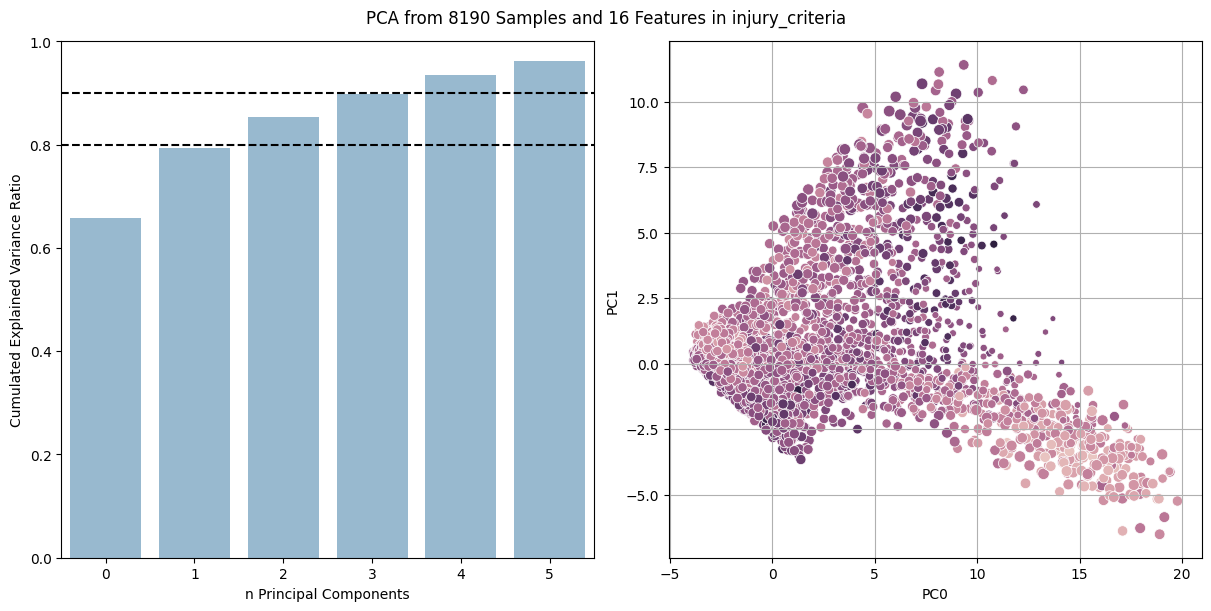

In [4]:
master(data=STR.fname_injury_crit)

2024-10-09 13:26:03,390     INFO  MainProcess  MainThread Reading data: channels.parquet
2024-10-09 13:26:03,392     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/channels.parquet' exists
2024-10-09 13:26:12,398     INFO  MainProcess  MainThread Data shape: (11474190, 43)
2024-10-09 13:26:12,399     INFO  MainProcess  MainThread Init Transformers
2024-10-09 13:26:12,400     INFO  MainProcess  MainThread Normalizer: RobustScaler(), PCA: PCA(n_components=0.95, svd_solver='full')
2024-10-09 13:26:12,401     INFO  MainProcess  MainThread Transforming data
2024-10-09 13:32:18,488     INFO  MainProcess  MainThread Data shape after PCA: (8190, 44)
2024-10-09 13:32:18,490     INFO  MainProcess  MainThread Plotting
2024-10-09 13:32:18,518     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-09 

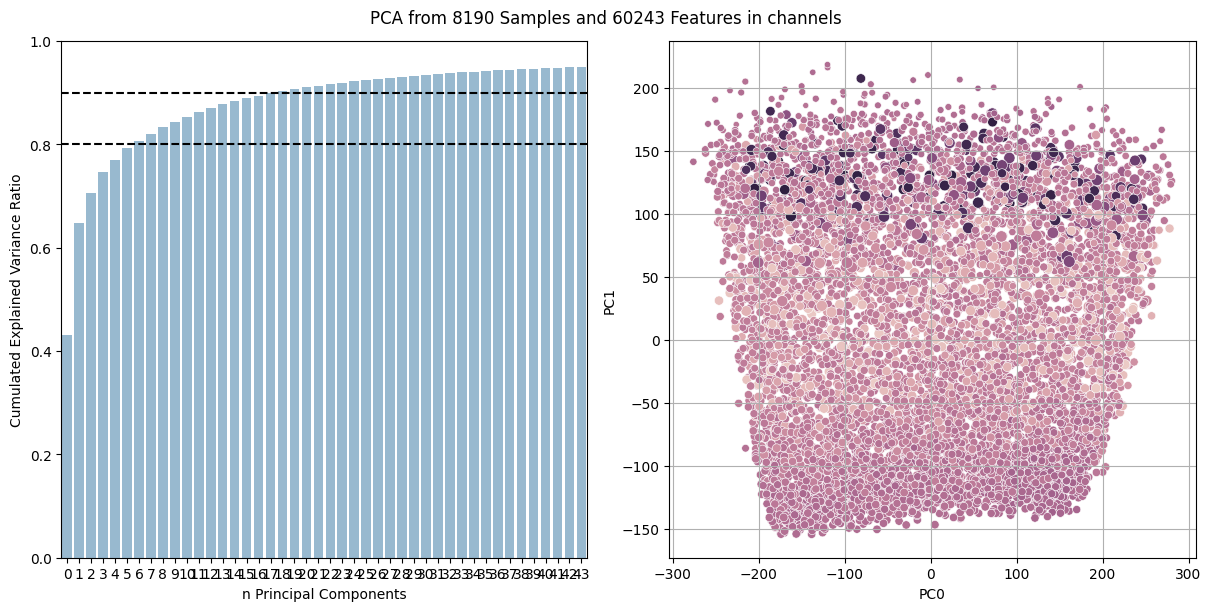

In [5]:
master(data=STR.fname_channels)

2024-10-09 13:32:19,358     INFO  MainProcess  MainThread Reading data: channels.parquet
2024-10-09 13:32:19,360     INFO  MainProcess  MainThread File 'data/doe/doe_sobol_20240705_194200/channels.parquet' exists
2024-10-09 13:32:25,574     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2024-10-09 13:32:25,575     INFO  MainProcess  MainThread Init Transformers
2024-10-09 13:32:25,575     INFO  MainProcess  MainThread Normalizer: RobustScaler(), PCA: PCA(n_components=0.95, svd_solver='full')
2024-10-09 13:32:25,576     INFO  MainProcess  MainThread Transforming data
2024-10-09 13:36:32,970     INFO  MainProcess  MainThread Data shape after PCA: (8190, 21)
2024-10-09 13:36:32,972     INFO  MainProcess  MainThread Plotting
2024-10-09 13:36:32,998     INFO  MainProcess  MainThread Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-09 

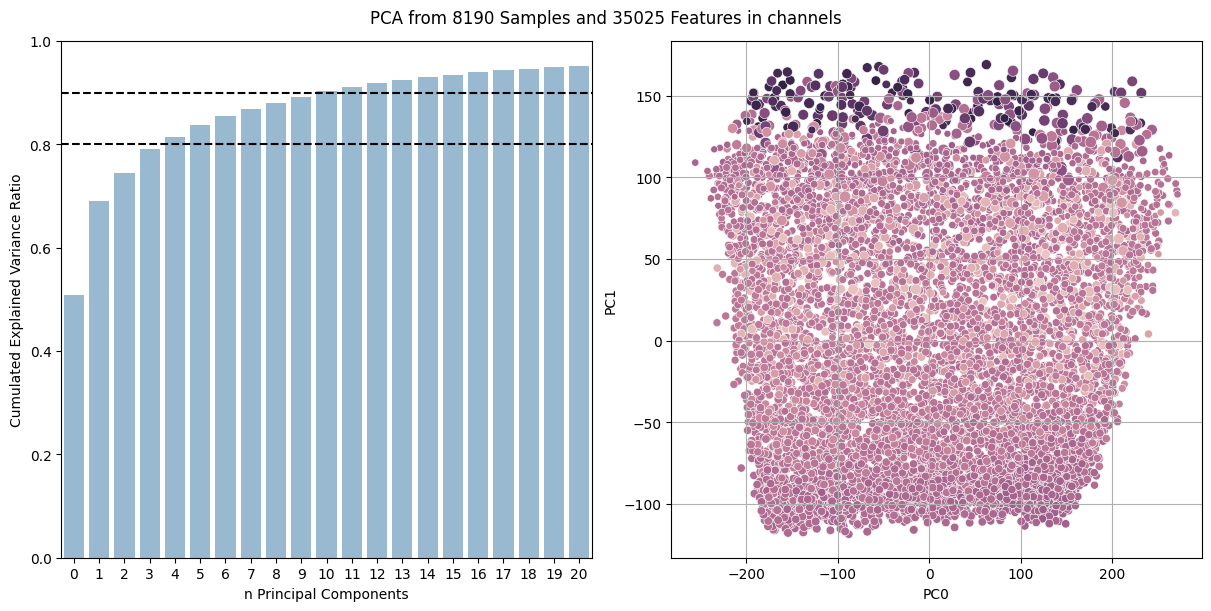

In [6]:
master(
    data=STR.fname_channels,
    columns=[
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03CHST0000OCCUDSXD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03FEMRLE00OCCUFOZD",
        "03FEMRRI00OCCUFOZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOYD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
    ],
)

In [28]:
def experiments(columns: List[str], steps: int = 20) -> None:
    LOG.info("Read Data")
    db = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db.shape)

    LOG.info("Resample Data")
    db = (
        db.unstack(level=STR.id)
        .rolling(window=steps, min_periods=0, step=steps, center=True)
        .mean()
        .stack(level=STR.id, future_stack=True)
        .reorder_levels(db.index.names)
        .sort_index()
    )
    LOG.info("Data shape after resample: %s", db.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db.copy()
    db_scal.loc[:, :] = scal.fit_transform(db)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.95, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)
    
    fig = px.scatter_3d(db_pca, x="PC1", y="PC2", z="PC3", color="PC4")
    fig.show()



experiments(
    columns=[
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03CHST0000OCCUDSXD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03FEMRLE00OCCUFOZD",
        "03FEMRRI00OCCUFOZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOYD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
    ]
)

2024-10-09 14:12:47,456     INFO  MainProcess  MainThread Read Data
2024-10-09 14:12:50,565     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2024-10-09 14:12:50,566     INFO  MainProcess  MainThread Resample Data
2024-10-09 14:13:07,065     INFO  MainProcess  MainThread Data shape after resample: (581490, 25)
2024-10-09 14:13:07,066     INFO  MainProcess  MainThread Normalize Data
2024-10-09 14:13:07,221     INFO  MainProcess  MainThread Data shape after normalization: (581490, 25)
2024-10-09 14:13:07,222     INFO  MainProcess  MainThread PCA
2024-10-09 14:13:22,316     INFO  MainProcess  MainThread Explained Variance Ratios: ['0.522', '0.693', '0.749', '0.795', '0.820', '0.840', '0.858', '0.872', '0.884', '0.894', '0.903', '0.912', '0.918', '0.924', '0.929', '0.934', '0.938', '0.941', '0.944', '0.948', '0.950']
2024-10-09 14:13:22,317     INFO  MainProcess  MainThread Data shape after PCA: (8190, 21)


2024-10-09 15:52:27,355     INFO  MainProcess  MainThread Read Target Data
2024-10-09 15:52:27,374     INFO  MainProcess  MainThread Data shape: (8192, 5)
2024-10-09 15:52:27,375     INFO  MainProcess  MainThread Read Feature Data
2024-10-09 15:52:30,337     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2024-10-09 15:52:30,338     INFO  MainProcess  MainThread Resample Data
2024-10-09 15:52:45,887     INFO  MainProcess  MainThread Data shape after resample: (581490, 25)
2024-10-09 15:52:45,888     INFO  MainProcess  MainThread Train Test Split
2024-10-09 15:52:45,937     INFO  MainProcess  MainThread Train IDs: 6552, Test IDs: 1638
2024-10-09 15:52:45,938     INFO  MainProcess  MainThread Normalize Data
2024-10-09 15:52:46,243     INFO  MainProcess  MainThread Data shape after normalization: (465192, 25)
2024-10-09 15:52:46,244     INFO  MainProcess  MainThread PCA
2024-10-09 15:52:53,833     INFO  MainProcess  MainThread Data shape after PCA: (6552, 73)
2024-10-09 15:52:53,

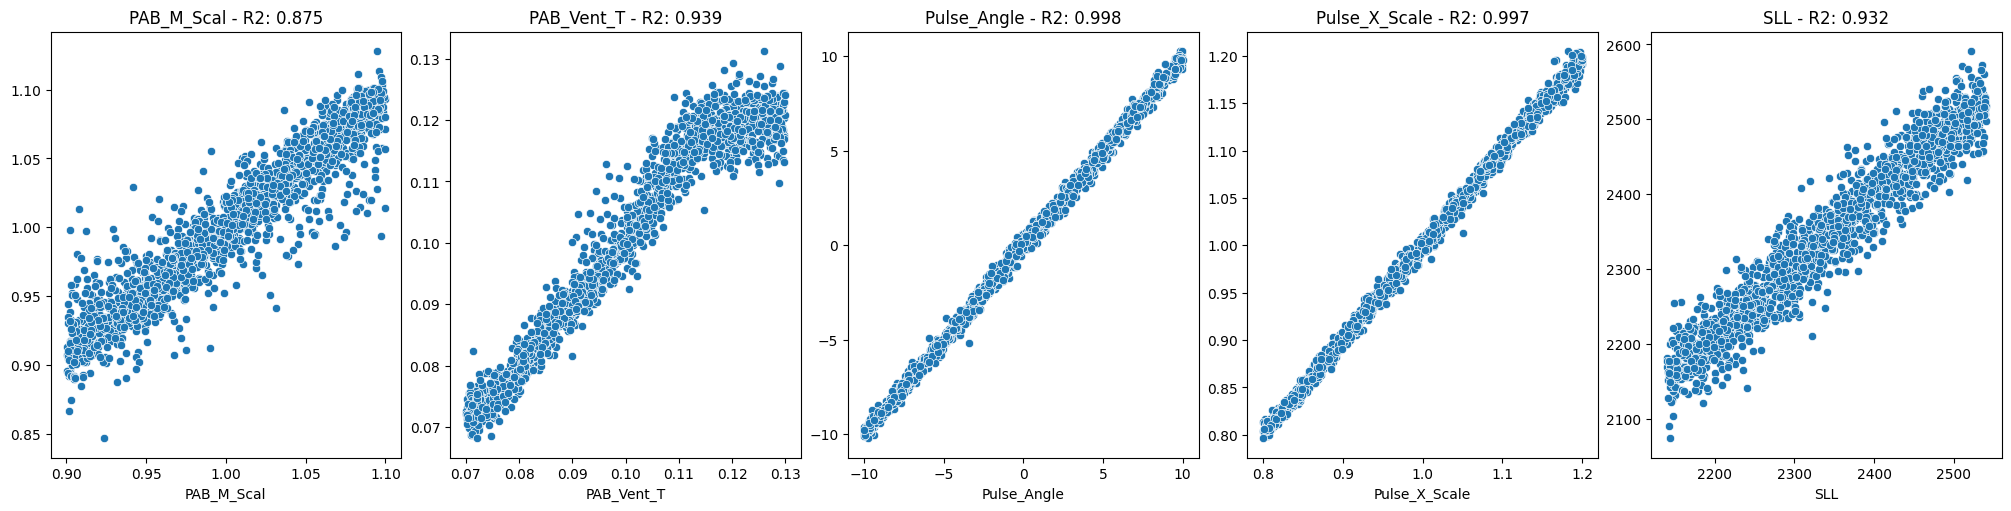

In [63]:
def some_learning():
    LOG.info("Read Target Data")
    db_target = (
        (pl.scan_parquet(source=D_DIR / "doe_combined.parquet").filter(pl.col(STR.perc) == 50).collect())
        .to_pandas()
        .drop(columns=STR.perc)
        .set_index(STR.sim_id)
    )
    conv = (
        (pl.scan_parquet(source=D_DIR / "sim_id_2_id.parquet").filter(pl.col(STR.perc) == 50).collect())
        .to_pandas()
        .drop(columns=STR.perc)
        .set_index(STR.sim_id)
    )
    db_target = db_target.join(conv).set_index(STR.id)
    del conv
    LOG.info("Data shape: %s", db_target.shape)

    LOG.info("Read Feature Data")
    db_feature = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .select(
                [
                    "03CHST0000OCCUACXD",
                    "03CHST0000OCCUACYD",
                    "03CHST0000OCCUACZD",
                    "03CHST0000OCCUDSXD",
                    "03CHSTLOC0OCCUDSXD",
                    "03CHSTLOC0OCCUDSYD",
                    "03CHSTLOC0OCCUDSZD",
                    "03FEMRLE00OCCUFOZD",
                    "03FEMRRI00OCCUFOZD",
                    "03HEAD0000OCCUACXD",
                    "03HEAD0000OCCUACYD",
                    "03HEAD0000OCCUACZD",
                    "03HEADLOC0OCCUDSXD",
                    "03HEADLOC0OCCUDSYD",
                    "03HEADLOC0OCCUDSZD",
                    "03NECKUP00OCCUFOXD",
                    "03NECKUP00OCCUFOYD",
                    "03NECKUP00OCCUFOZD",
                    "03NECKUP00OCCUMOYD",
                    "03PELV0000OCCUACXD",
                    "03PELV0000OCCUACYD",
                    "03PELV0000OCCUACZD",
                    "03PELVLOC0OCCUDSXD",
                    "03PELVLOC0OCCUDSYD",
                    "03PELVLOC0OCCUDSZD",
                ]
                + [STR.time, pl.col(STR.id).cast(pl.Int32)]
            )
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db_feature.shape)

    LOG.info("Resample Data")
    db_feature = (
        db_feature.unstack(level=STR.id)
        .rolling(window=20, min_periods=0, step=20, center=True)
        .mean()
        .stack(level=STR.id, future_stack=True)
        .reorder_levels(db_feature.index.names)
        .sort_index()
    )
    LOG.info("Data shape after resample: %s", db_feature.shape)

    LOG.info("Train Test Split")
    rng = np.random.default_rng()
    all_idx = set(db_feature.index.get_level_values(STR.id))
    train_ids = sorted(rng.choice(sorted(all_idx), size=int(0.8 * len(all_idx)), replace=False))
    test_ids = sorted(all_idx - set(train_ids))
    LOG.info("Train IDs: %s, Test IDs: %s", len(train_ids), len(test_ids))

    LOG.info("Normalize Data")
    scal_feat = StandardScaler()
    scal_targ = StandardScaler()
    db_scal = db_feature.loc[(train_ids, slice(None)), :].copy()
    db_scal.loc[:, :] = scal_feat.fit_transform(db_scal)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.99, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    LOG.info("Train")
    regressor = MLPRegressor(early_stopping=True, n_iter_no_change=50, alpha=0.5, max_iter=2000, learning_rate_init=2e-4, hidden_layer_sizes=(db_target.shape[1]*8, db_target.shape[1]*4, db_target.shape[1]*2))
    regressor.fit(db_pca.loc[train_ids], scal_targ.fit_transform(db_target.loc[train_ids]))
    LOG.info("Trained %s iterations", regressor.n_iter_)
    sc_train = pd.Series(
        r2_score(
            y_true=scal_targ.transform(db_target.loc[train_ids]),
            y_pred=regressor.predict(db_pca.loc[train_ids]),
            multioutput="raw_values",
        ),
        index=db_target.columns,
    )
    LOG.info("Train Score:\n%s", sc_train)

    LOG.info("Test")
    db_scal = db_feature.loc[(test_ids, slice(None)), :].copy()
    db_scal.loc[:, :] = scal_feat.transform(db_scal)
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    y_pred = scal_targ.inverse_transform(regressor.predict(db_pca.loc[test_ids]))
    sc_test = pd.Series(
        r2_score(
            y_true=db_target.loc[test_ids],
            y_pred=y_pred,
            multioutput="raw_values",
        ),
        index=db_target.columns,
    )
    LOG.info("Test Score:\n%s", sc_test)

    LOG.info("Cross Plots per Target")
    fig, ax = plt.subplots(ncols=db_target.shape[1], figsize=(20, 5), layout="constrained")
    for i, col in enumerate(db_target.columns):
        sns.scatterplot(x=db_target.loc[test_ids, col], y=y_pred[:, i], ax=ax[i])
        ax[i].set_title(f"{col} - R2: {sc_test[col]:.3f}")

    LOG.info("Done")


some_learning()

2024-11-06 10:55:10,785     INFO  MainProcess  MainThread Read Data


2024-11-06 10:55:17,504     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2024-11-06 10:55:17,506     INFO  MainProcess  MainThread Resample Data
2024-11-06 10:55:29,352     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 140
2024-11-06 10:58:04,331     INFO  MainProcess  MainThread Data shape after resample: (1146600, 25)
2024-11-06 10:58:04,333     INFO  MainProcess  MainThread Normalize Data
2024-11-06 10:58:04,920     INFO  MainProcess  MainThread Data shape after normalization: (1146600, 25)
2024-11-06 10:58:04,922     INFO  MainProcess  MainThread PCA
2024-11-06 10:59:28,844     INFO  MainProcess  MainThread Explained Variance Ratios: ['0.518', '0.689', '0.744', '0.790', '0.815', '0.836', '0.854', '0.868', '0.881', '0.891', '0.900', '0.909', '0.916', '0.922', '0.927', '0.932', '0.935', '0.939', '0.943', '0.946', '0.949', '0.951']
2024-11-06 10:59:28,845     INFO  MainProcess  MainThread Data shape after PCA: (8190, 22)
2024-11-06 10:59:28,846     IN

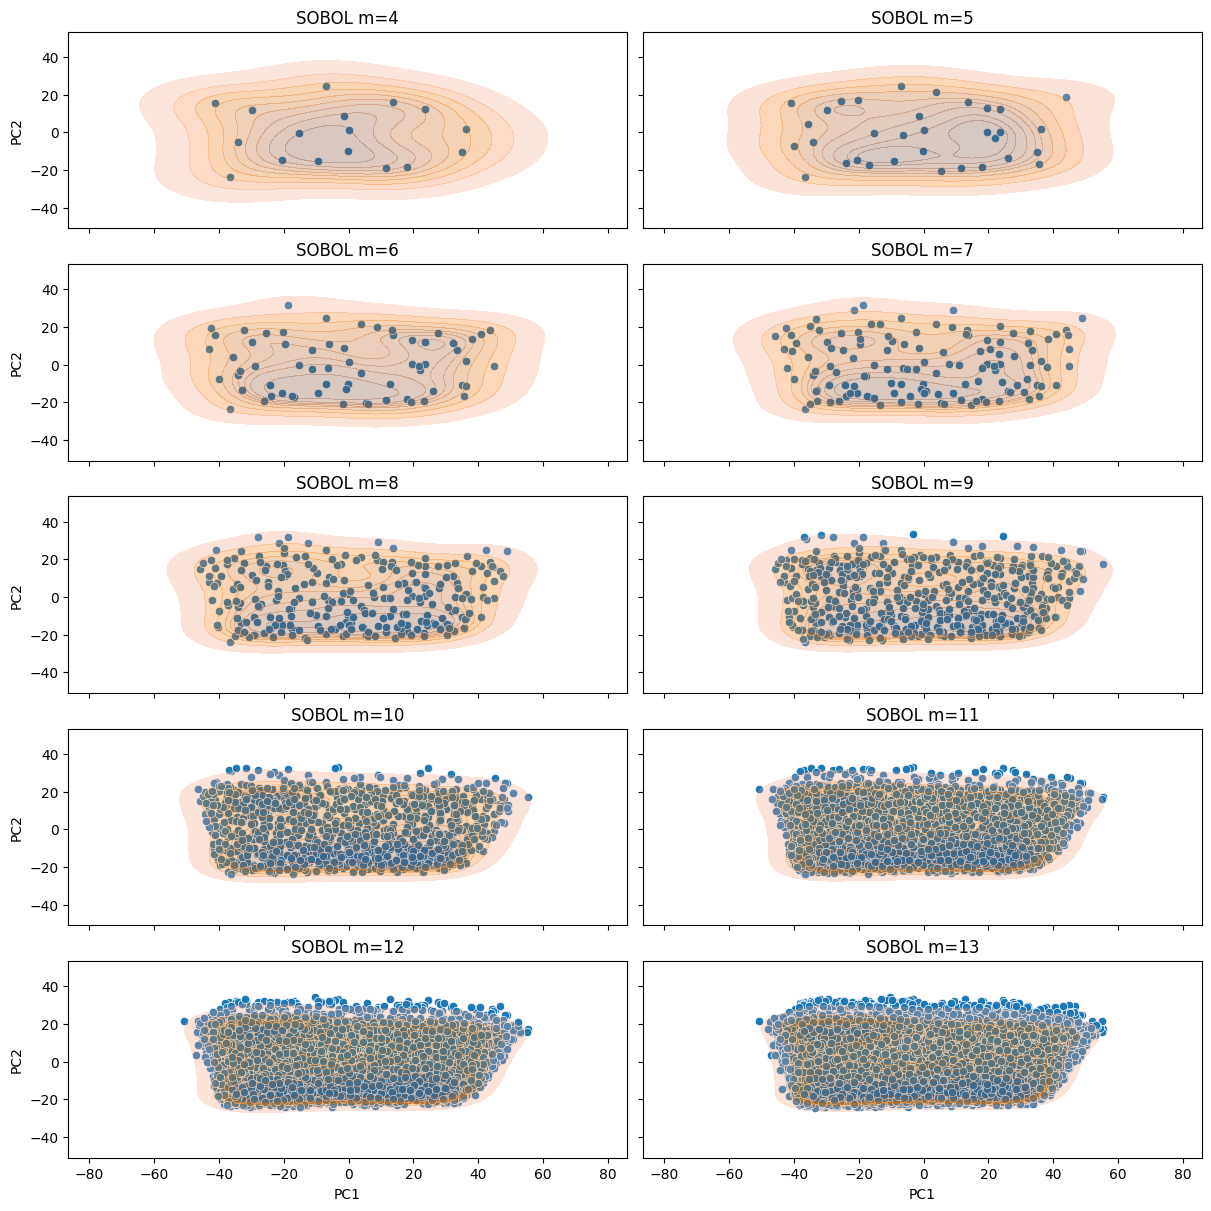

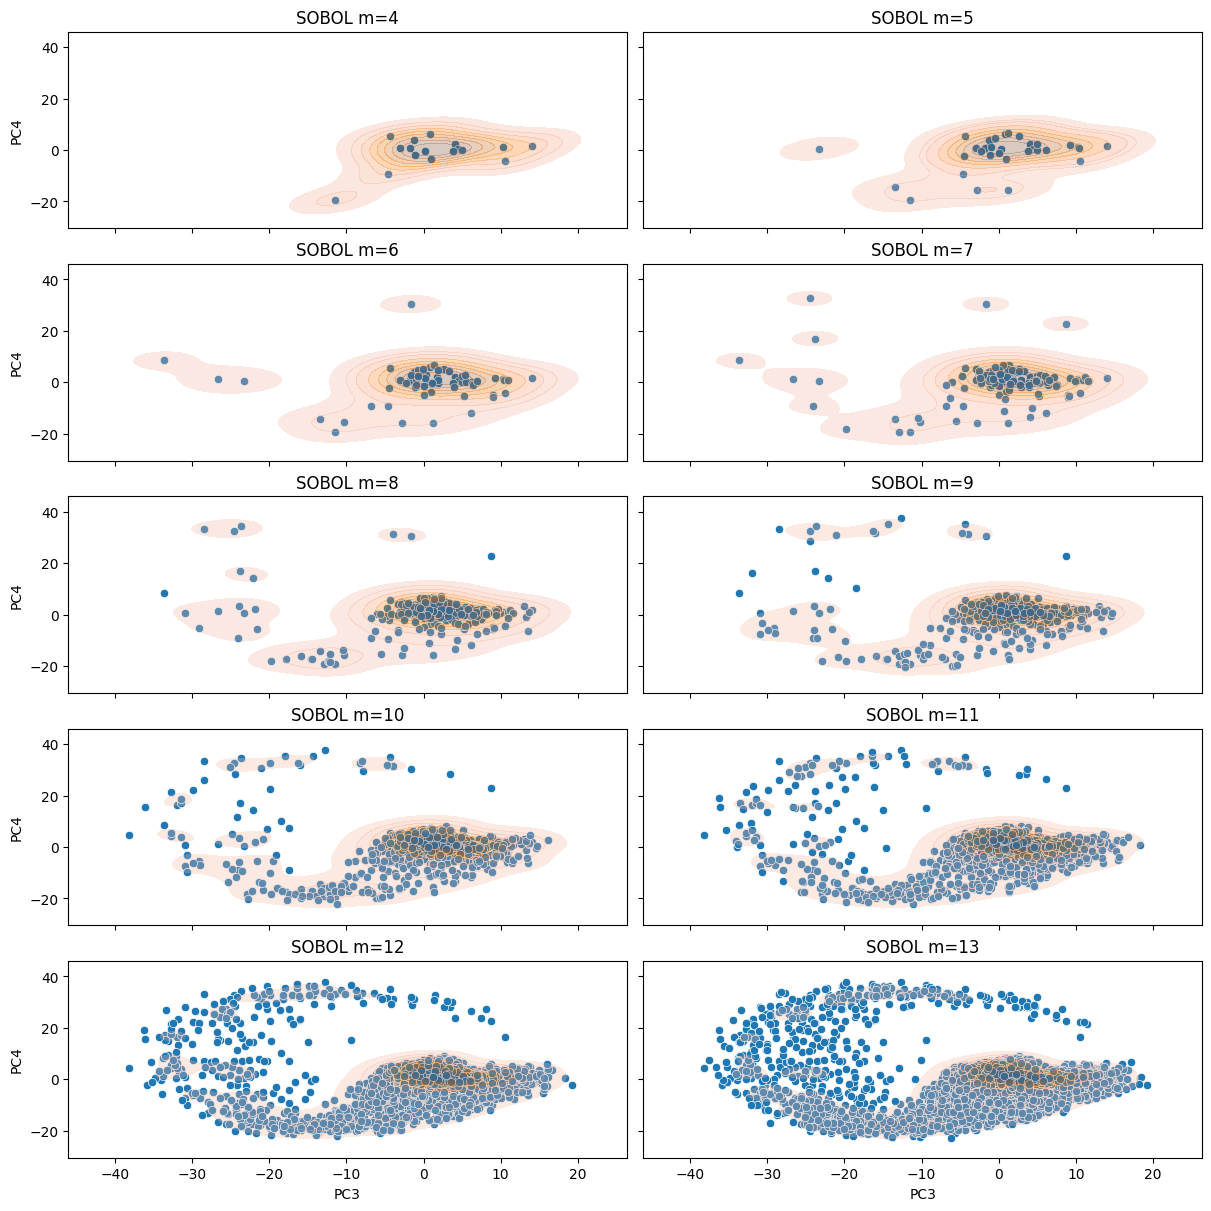

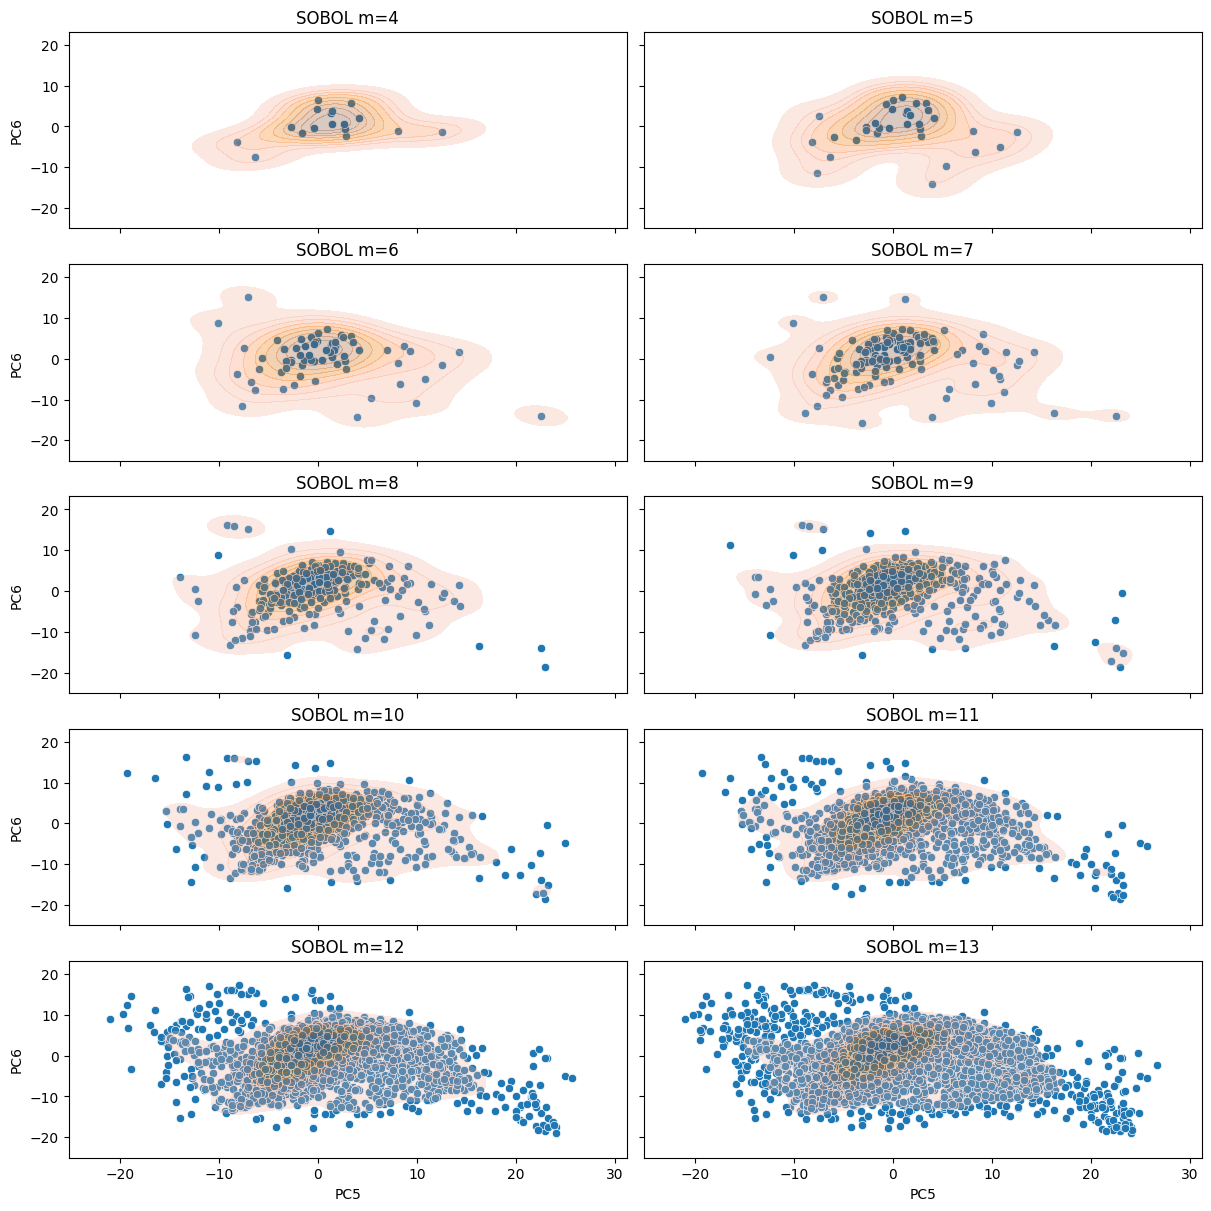

In [57]:
def experiments_2(columns: List[str], new_n_tsps: int = 140, sobol_m_max: int = 13) -> None:
    n_max = 2**sobol_m_max
    m_n = [(m, 2**m) for m in range(1, sobol_m_max + 10)]

    LOG.info("Read Data")
    db = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .filter(pl.col(STR.id) < n_max)
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db.shape)

    LOG.info("Resample Data")
    db = get_temporal_resampled(db_in=db, new_n_tsps=new_n_tsps)
    LOG.info("Data shape after resample: %s", db.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db.copy()
    db_scal.loc[:, :] = scal.fit_transform(db)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.95, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    # plot
    LOG.info("Plotting")
    """fig, ax = plt.subplots(figsize=(12, 6), layout="constrained")
    # sns.scatterplot(data=db_pca, x="PC1", y="PC2",hue="SOBOL m", ax=ax)
    frames = []
    for m in range(1, sobol_m_max + 1):
        frames.append(db_pca.loc[: 2**m].copy())
        frames[-1]["Sobol m"] = str(m)
    frames = pd.concat(frames)
    display(frames)
    sns.kdeplot(data=frames, x="PC1", y="PC2", hue="Sobol m", ax=ax, fill=True, alpha=0.3)
    ax.grid()"""
    ms = list(range(4, sobol_m_max + 1))
    for pc1, pc2 in [(1, 2), (3, 4), (5, 6)]:
        fig, ax = plt.subplot_mosaic(
            mosaic=np.reshape(ms, (len(ms) // 2, 2)),
            figsize=(12, 12),
            layout="constrained",
            sharex=True,
            sharey=True,
        )
        for m in ms:
            sns.scatterplot(
                data=db_pca.loc[: 2**m],
                x=f"PC{pc1}",
                y=f"PC{pc2}",
                ax=ax[m],
            )

            sns.kdeplot(
                data=db_pca.loc[: 2**m],
                x=f"PC{pc1}",
                y=f"PC{pc2}",
                ax=ax[m],
                fill=True,
                alpha=0.3,
            )
            ax[m].set_title(f"SOBOL m={m}")
    LOG.info("Plotting done")


experiments_2(
    columns=[
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03CHST0000OCCUDSXD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03FEMRLE00OCCUFOZD",
        "03FEMRRI00OCCUFOZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOYD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
    ],
    sobol_m_max=13,
)

In [6]:
from itertools import permutations, combinations
list(combinations([1,2,3,4], 2))

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

(<Figure size 640x480 with 18 Axes>,
 {'1_1_2': <Axes: label='1_1_2'>,
  '2_1_2': <Axes: label='2_1_2'>,
  '3_1_2': <Axes: label='3_1_2'>,
  '1_1_3': <Axes: label='1_1_3'>,
  '2_1_3': <Axes: label='2_1_3'>,
  '3_1_3': <Axes: label='3_1_3'>,
  '1_1_4': <Axes: label='1_1_4'>,
  '2_1_4': <Axes: label='2_1_4'>,
  '3_1_4': <Axes: label='3_1_4'>,
  '1_2_3': <Axes: label='1_2_3'>,
  '2_2_3': <Axes: label='2_2_3'>,
  '3_2_3': <Axes: label='3_2_3'>,
  '1_2_4': <Axes: label='1_2_4'>,
  '2_2_4': <Axes: label='2_2_4'>,
  '3_2_4': <Axes: label='3_2_4'>,
  '1_3_4': <Axes: label='1_3_4'>,
  '2_3_4': <Axes: label='2_3_4'>,
  '3_3_4': <Axes: label='3_3_4'>})

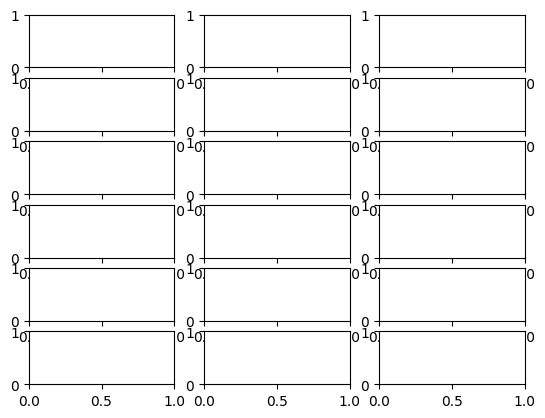

In [67]:
plt.subplot_mosaic([[f"{m}_{i}_{j}" for m in (1,2,3)] for i, j in combinations([1, 2, 3, 4], 2)])

2024-12-31 14:09:03,297     INFO  MainProcess  MainThread Read Data


2024-12-31 14:09:09,953     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2024-12-31 14:09:09,954     INFO  MainProcess  MainThread Resample Data
2024-12-31 14:09:21,381     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 140
2024-12-31 14:11:21,375     INFO  MainProcess  MainThread Data shape after resample: (1146600, 25)
2024-12-31 14:11:21,376     INFO  MainProcess  MainThread Normalize Data
2024-12-31 14:11:21,884     INFO  MainProcess  MainThread Data shape after normalization: (1146600, 25)
2024-12-31 14:11:21,885     INFO  MainProcess  MainThread PCA
2024-12-31 14:13:16,601     INFO  MainProcess  MainThread Explained Variance Ratios: ['0.518', '0.689', '0.744', '0.790', '0.815', '0.836', '0.854', '0.868', '0.881', '0.891', '0.900', '0.909', '0.916', '0.922', '0.927', '0.932', '0.935', '0.939', '0.943', '0.946', '0.949', '0.951']
2024-12-31 14:13:16,603     INFO  MainProcess  MainThread Data shape after PCA: (8190, 22)
2024-12-31 14:13:16,603     IN

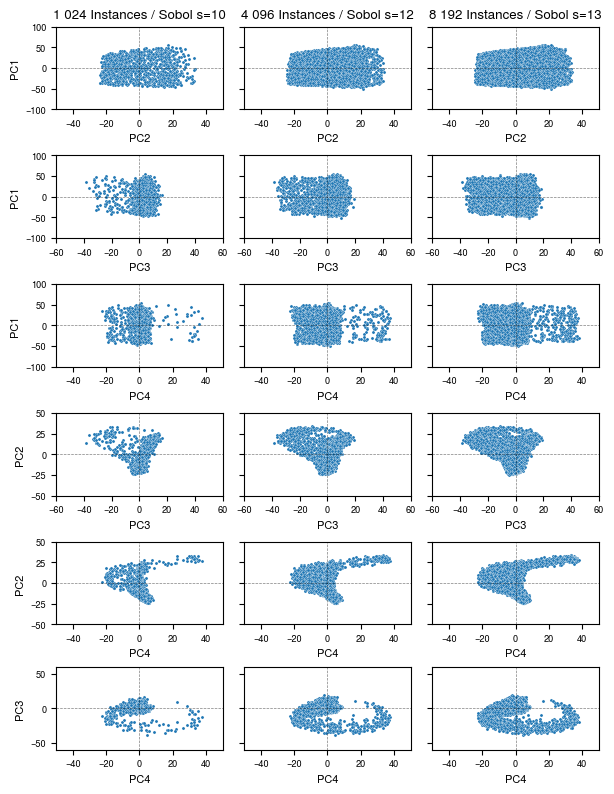

In [29]:
def experiments_3(columns: List[str], new_n_tsps: int = 140, sobol_m_max: int = 13) -> None:
    n_max = 2**sobol_m_max
    m_n = [(m, 2**m) for m in range(1, sobol_m_max + 10)]

    LOG.info("Read Data")
    db = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .filter(pl.col(STR.id) < n_max)
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db.shape)

    LOG.info("Resample Data")
    db = get_temporal_resampled(db_in=db, new_n_tsps=new_n_tsps)
    LOG.info("Data shape after resample: %s", db.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db.copy()
    db_scal.loc[:, :] = scal.fit_transform(db)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.95, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    # plot
    LOG.info("Plotting")
    ms = (10, 12, 13)
    dims = [[f"{m}_{i}_{j}" for m in ms] for i, j in combinations([1, 2, 3, 4], 2)]
    fig, ax = plt.subplot_mosaic(
        dims,
        layout="constrained",
    )
    no_label = []
    for row in dims:
        for i, _ in enumerate(row):
            if i != 0:
                no_label.append(row[i])
    no_label = set(no_label)

    for sub in sum(dims, []):
        ax[sub].axhline(0, c="black", ls="--", lw=0.5, alpha=0.5)
        ax[sub].axvline(0, c="black", ls="--", lw=0.5, alpha=0.5)

        m, pc_y, pc_x = sub.split("_")
        sns.scatterplot(
            data=db_pca.loc[: 2 ** int(m)],
            x=f"PC{pc_x}",
            y=f"PC{pc_y}",
            ax=ax[sub],
            s=5,
        )

        if sub in dims[0]:
            ax[sub].set_title(f"{2**int(m):,} Instances / Sobol s={m}".replace(",", " "))
        if sub in no_label:
            ax[sub].set_yticklabels([])
            ax[sub].set_ylabel("")

        lims = {"1": [-100, 100], "2": [-50, 50], "3": [-60, 60], "4": [-50, 50]}
        ax[sub].set_xlim(lims[pc_x])
        ax[sub].set_ylim(lims[pc_y])

    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * WIDTH)
    LOG.info("Plotting done")
    fig.savefig(FIG_DIR / "pca_sobol.pdf")


experiments_3(
    columns=[
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03CHST0000OCCUDSXD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03FEMRLE00OCCUFOZD",
        "03FEMRRI00OCCUFOZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOYD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
    ],
    sobol_m_max=13,
)

2025-01-05 09:10:57,468     INFO  MainProcess  MainThread Read Data
2025-01-05 09:11:06,896     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2025-01-05 09:11:06,897     INFO  MainProcess  MainThread Resample Data
2025-01-05 09:11:20,058     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 140
2025-01-05 09:12:51,164     INFO  MainProcess  MainThread Data shape after resample: (1146600, 25)
2025-01-05 09:12:51,165     INFO  MainProcess  MainThread Normalize Data
2025-01-05 09:12:51,597     INFO  MainProcess  MainThread Data shape after normalization: (1146600, 25)
2025-01-05 09:12:51,598     INFO  MainProcess  MainThread PCA
2025-01-05 09:13:56,255     INFO  MainProcess  MainThread Explained Variance Ratios: ['0.518', '0.689', '0.744', '0.790', '0.815', '0.836', '0.854', '0.868', '0.881', '0.891', '0.900', '0.909', '0.916', '0.922', '0.927', '0.932', '0.935', '0.939', '0.943', '0.946', '0.949', '0.951']
2025-01-05 09:13:56,256     INFO  MainProcess  MainTh

SOBOL m=0: 5.482e+00, PCA 4: 4.158e-01, PCA Full: 6.694e+00
SOBOL m=1: 1.339e+00, PCA 4: 4.282e-01, PCA Full: 6.155e+00
SOBOL m=2: 3.839e-01, PCA 4: 2.533e-01, PCA Full: 5.370e+00
SOBOL m=3: 1.276e-01, PCA 4: 2.214e-01, PCA Full: 4.497e+00
SOBOL m=4: 3.461e-02, PCA 4: 2.053e-01, PCA Full: 4.168e+00
SOBOL m=5: 9.759e-03, PCA 4: 1.826e-01, PCA Full: 3.934e+00
SOBOL m=6: 3.121e-03, PCA 4: 1.713e-01, PCA Full: 3.747e+00
SOBOL m=7: 7.998e-04, PCA 4: 1.673e-01, PCA Full: 3.712e+00
SOBOL m=8: 2.598e-04, PCA 4: 1.620e-01, PCA Full: 3.638e+00
SOBOL m=9: 7.771e-05, PCA 4: 1.607e-01, PCA Full: 3.632e+00
SOBOL m=10: 2.525e-05, PCA 4: 1.619e-01, PCA Full: 3.663e+00
SOBOL m=11: 7.423e-06, PCA 4: 1.611e-01, PCA Full: 3.663e+00
SOBOL m=12: 2.231e-06, PCA 4: 1.610e-01, PCA Full: 3.664e+00
SOBOL m=13: 7.641e-07, PCA 4: 1.612e-01, PCA Full: 3.665e+00


2025-01-05 09:14:01,833     INFO  MainProcess  MainThread maxp pruned
2025-01-05 09:14:01,838     INFO  MainProcess  MainThread cmap pruned
2025-01-05 09:14:01,840     INFO  MainProcess  MainThread post pruned
2025-01-05 09:14:01,842     INFO  MainProcess  MainThread CFF  pruned
2025-01-05 09:14:01,845     INFO  MainProcess  MainThread GPOS pruned
2025-01-05 09:14:01,855     INFO  MainProcess  MainThread GSUB pruned
2025-01-05 09:14:01,857     INFO  MainProcess  MainThread Added .notdef to subset
2025-01-05 09:14:01,859     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 32 glyphs before
2025-01-05 09:14:01,860     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'C', 'D', 'F', 'I', 'N', 'P', 'S', 'a', 'b', 'c', 'e', 'f', 'five', 'four', 'i', 'l', 'm', 'minus', 'n', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
2025-01-05 09:14:01,861     INFO  MainProcess  MainThread Glyph IDs:   [0, 29, 36, 43, 44, 47, 51, 55, 56, 57, 58, 66, 67, 73, 7

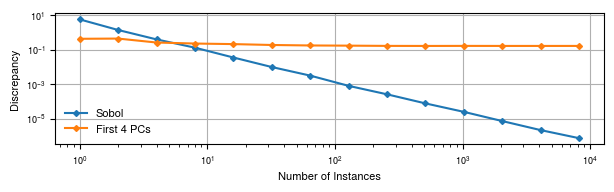

In [74]:
def experiments_4(columns: List[str], new_n_tsps: int = 140, sobol_m_max: int = 13) -> None:
    n_max = 2**sobol_m_max

    LOG.info("Read Data")
    db = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .filter(pl.col(STR.id) < n_max)
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db.shape)

    LOG.info("Resample Data")
    db = get_temporal_resampled(db_in=db, new_n_tsps=new_n_tsps)
    LOG.info("Data shape after resample: %s", db.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db.copy()
    db_scal.loc[:, :] = scal.fit_transform(db)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.95, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    scal = MinMaxScaler()
    db_pca.loc[:, :] = scal.fit_transform(db_pca)

    ms = list(range(0, sobol_m_max + 1))
    disc_sobols = []
    disc_pca_4s = []

    for m in ms:
        # sobol
        generator = Sobol(
            d=5,
            scramble=False,
            seed=None,
            optimization=None,
        )
        samples = generator.random_base2(m=m)
        disc_sobol = discrepancy(samples)

        disc_pca_4 = discrepancy(db_pca.loc[: 2**m, list(db_pca.columns[:4])].values)
        disc_pca_full = discrepancy(db_pca.loc[: 2**m].values)

        print(f"SOBOL m={m}: {disc_sobol:.3e}, PCA 4: {disc_pca_4:.3e}, PCA Full: {disc_pca_full:.3e}")

        disc_sobols.append(disc_sobol)
        disc_pca_4s.append(disc_pca_4)

    fig, ax = plt.subplots(layout="constrained")
    ax.plot([2**m for m in ms], disc_sobols, label="Sobol", marker="D", lw=1.5, markersize=3)
    ax.plot([2**m for m in ms], disc_pca_4s, label="First 4 PCs", marker="D",  lw=1.5, markersize=3)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    ax.grid()
    ax.set_xlabel("Number of Instances")
    ax.set_ylabel("Discrepancy")

    fig.set_figwidth(WIDTH)
    fig.set_figheight(0.3 * WIDTH)
    fig.savefig(FIG_DIR / "discrepancy_sobol_vs_pca.pdf")


experiments_4(
    columns=[
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03CHST0000OCCUDSXD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03FEMRLE00OCCUFOZD",
        "03FEMRRI00OCCUFOZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOYD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
    ],
    sobol_m_max=13,
)

In [13]:
def experiments_5(
    columns: List[str],
    new_n_tsps: int = 140,
    sobol_m_max: int = 13,
    pca_kernel: Literal["linear", "poly", "rbf", "sigmoid", "cosine"] = "rbf",
) -> None:
    n_max = 2**sobol_m_max

    LOG.info("Read Data")
    db = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .filter(pl.col(STR.id) < n_max)
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db.shape)

    LOG.info("Resample Data")
    db = get_temporal_resampled(db_in=db, new_n_tsps=new_n_tsps)
    LOG.info("Data shape after resample: %s", db.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db.copy()
    db_scal.loc[:, :] = scal.fit_transform(db)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = KernelPCA(kernel=pca_kernel)
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pca.fit_transform(tmp)
    db_pca = pd.DataFrame(db_pca, columns=[f"PC{i+1}" for i in range(db_pca.shape[1])], index=tmp.index)
    #LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    # plot
    LOG.info("Plotting")
    ms = (10, 12, 13)
    dims = [[f"{m}_{i}_{j}" for m in ms] for i, j in combinations([1, 2, 3, 4], 2)]
    fig, ax = plt.subplot_mosaic(
        dims,
        figsize=(WIDTH, 1.3 * WIDTH),
        layout="constrained",
    )

    for sub in sum(dims, []):
        ax[sub].axhline(0, c="black", ls="--", lw=0.5, alpha=0.5)
        ax[sub].axvline(0, c="black", ls="--", lw=0.5, alpha=0.5)

        m, pc_y, pc_x = sub.split("_")
        sns.scatterplot(
            data=db_pca.loc[: 2 ** int(m)],
            x=f"PC{pc_x}",
            y=f"PC{pc_y}",
            ax=ax[sub],
            s=5,
        )

        if sub in dims[0]:
            ax[sub].set_title(f"m={m}, n={2**int(m):,}", weight="bold")

        lims = {"1": [-100, 100], "2": [-50, 50], "3": [-60, 60], "4": [-50, 50]}
        #ax[sub].set_xlim(lims[pc_x])
        #ax[sub].set_ylim(lims[pc_y])

    LOG.info("Plotting done")
    fig.savefig(FIG_DIR / f"pca_sobol_kernel_{pca_kernel}.pdf")
    plt.close(fig)

for k in ["linear", "poly", "rbf", "sigmoid", "cosine"]:
    experiments_5(
        columns=[
            "03CHST0000OCCUACXD",
            "03CHST0000OCCUACYD",
            "03CHST0000OCCUACZD",
            "03CHST0000OCCUDSXD",
            "03CHSTLOC0OCCUDSXD",
            "03CHSTLOC0OCCUDSYD",
            "03CHSTLOC0OCCUDSZD",
            "03FEMRLE00OCCUFOZD",
            "03FEMRRI00OCCUFOZD",
            "03HEAD0000OCCUACXD",
            "03HEAD0000OCCUACYD",
            "03HEAD0000OCCUACZD",
            "03HEADLOC0OCCUDSXD",
            "03HEADLOC0OCCUDSYD",
            "03HEADLOC0OCCUDSZD",
            "03NECKUP00OCCUFOXD",
            "03NECKUP00OCCUFOYD",
            "03NECKUP00OCCUFOZD",
            "03NECKUP00OCCUMOYD",
            "03PELV0000OCCUACXD",
            "03PELV0000OCCUACYD",
            "03PELV0000OCCUACZD",
            "03PELVLOC0OCCUDSXD",
            "03PELVLOC0OCCUDSYD",
            "03PELVLOC0OCCUDSZD",
        ],
        sobol_m_max=13,
        pca_kernel=k,
    )

2024-11-06 17:13:00,272     INFO  MainProcess  MainThread Read Data


2024-11-06 17:13:05,178     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2024-11-06 17:13:05,179     INFO  MainProcess  MainThread Resample Data
2024-11-06 17:13:18,037     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 140
2024-11-06 17:15:46,993     INFO  MainProcess  MainThread Data shape after resample: (1146600, 25)
2024-11-06 17:15:46,996     INFO  MainProcess  MainThread Normalize Data
2024-11-06 17:15:47,614     INFO  MainProcess  MainThread Data shape after normalization: (1146600, 25)
2024-11-06 17:15:47,617     INFO  MainProcess  MainThread PCA
2024-11-06 17:18:11,387     INFO  MainProcess  MainThread Data shape after PCA: (8190, 2206)
2024-11-06 17:18:11,388     INFO  MainProcess  MainThread Plotting
2024-11-06 17:18:13,271     INFO  MainProcess  MainThread Plotting done
2024-11-06 17:18:21,159     INFO  MainProcess  MainThread maxp pruned
2024-11-06 17:18:21,169     INFO  MainProcess  MainThread cmap pruned
2024-11-06 17:18:21,170     INFO 

ValueError: There are significant negative eigenvalues (0.128282 of the maximum positive). Either the matrix is not PSD, or there was an issue while computing the eigendecomposition of the matrix.

2024-11-06 16:53:07,757     INFO  MainProcess  MainThread Read Channel Data
2024-11-06 16:53:10,959     INFO  MainProcess  MainThread Data channel shape: (5725887, 25)
2024-11-06 16:53:10,961     INFO  MainProcess  MainThread Read Injury Data
2024-11-06 16:53:10,977     INFO  MainProcess  MainThread Data Injury shape: (4087, 8)
2024-11-06 16:53:10,978     INFO  MainProcess  MainThread Resample Data
2024-11-06 16:53:17,533     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 140
2024-11-06 16:54:32,491     INFO  MainProcess  MainThread Data shape after resample: (572180, 25)
2024-11-06 16:54:32,493     INFO  MainProcess  MainThread Normalize Data
2024-11-06 16:54:32,697     INFO  MainProcess  MainThread Data shape after normalization: (572180, 25)
2024-11-06 16:54:32,698     INFO  MainProcess  MainThread PCA
2024-11-06 16:55:46,644     INFO  MainProcess  MainThread Explained Variance Ratios: ['0.505', '0.738', '0.795', '0.831', '0.854', '0.870', '0.884', '0.892', '0.9

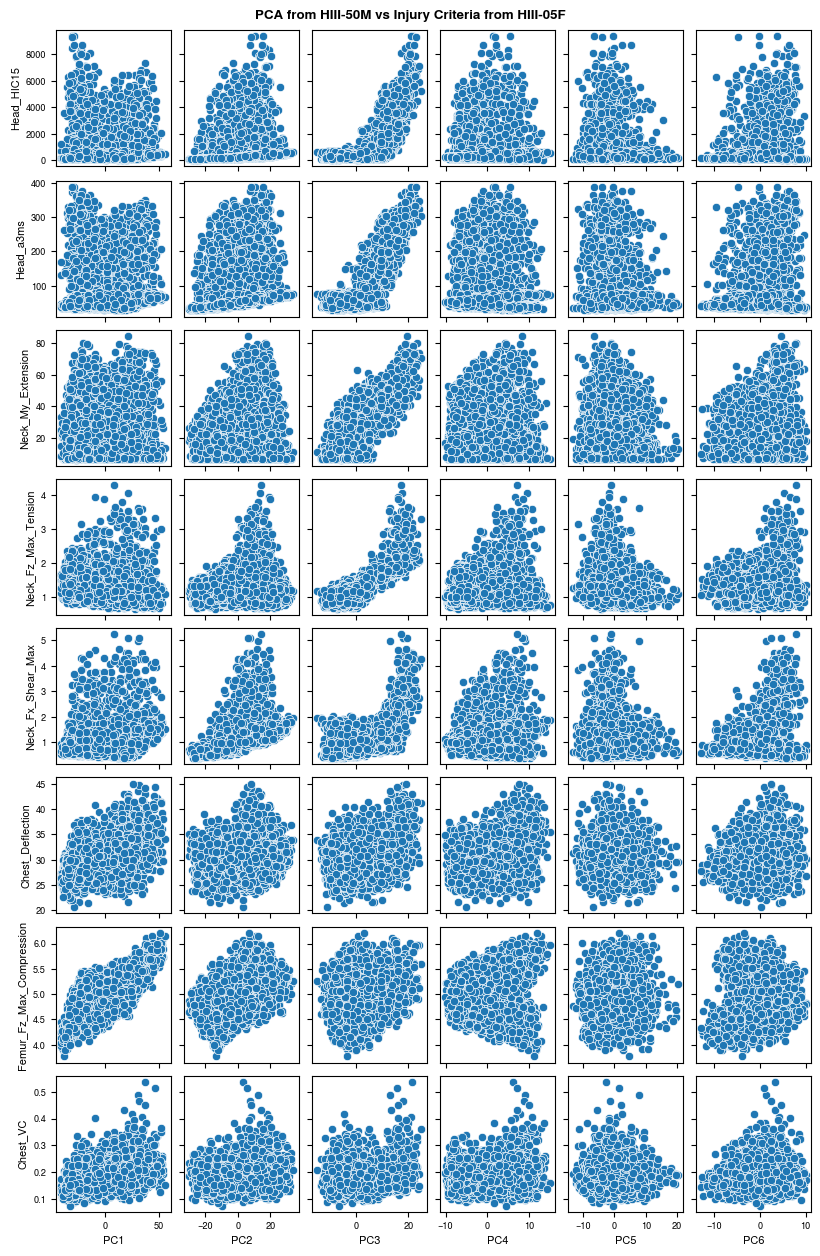

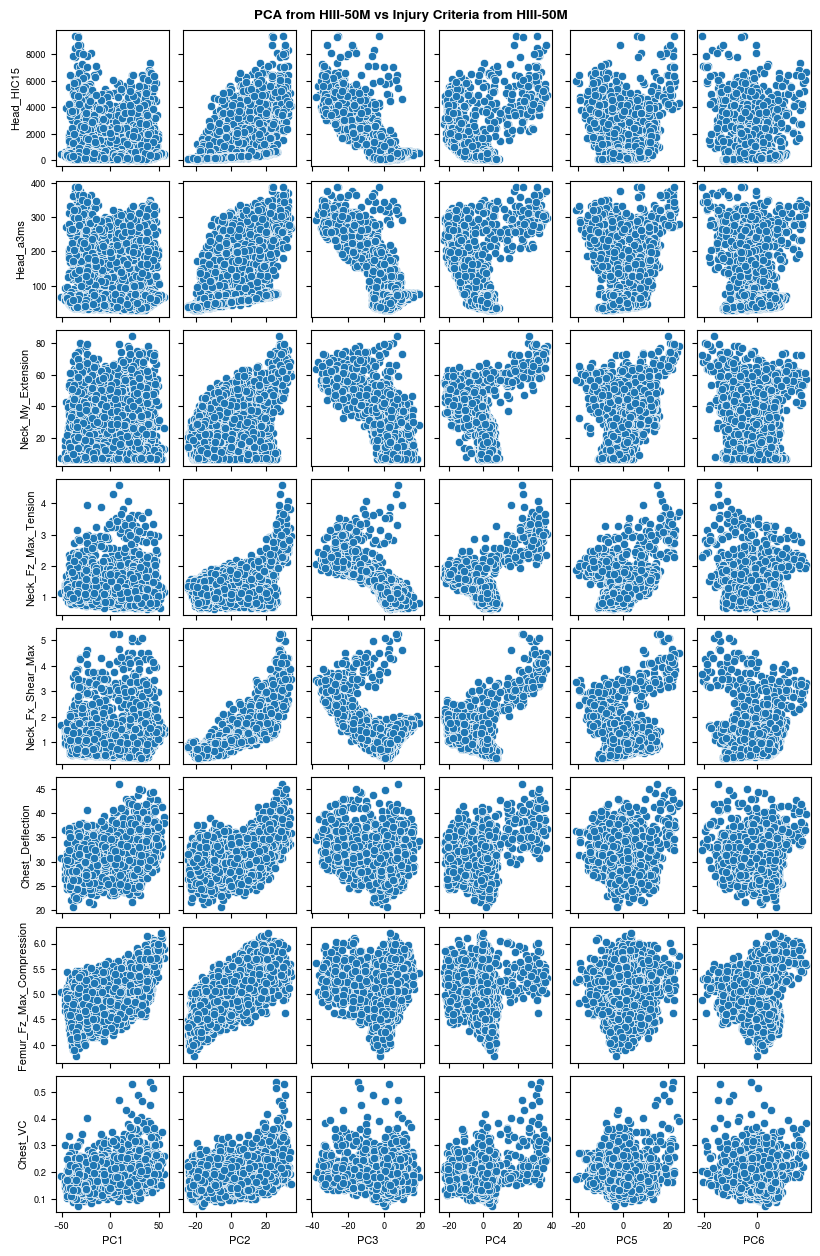

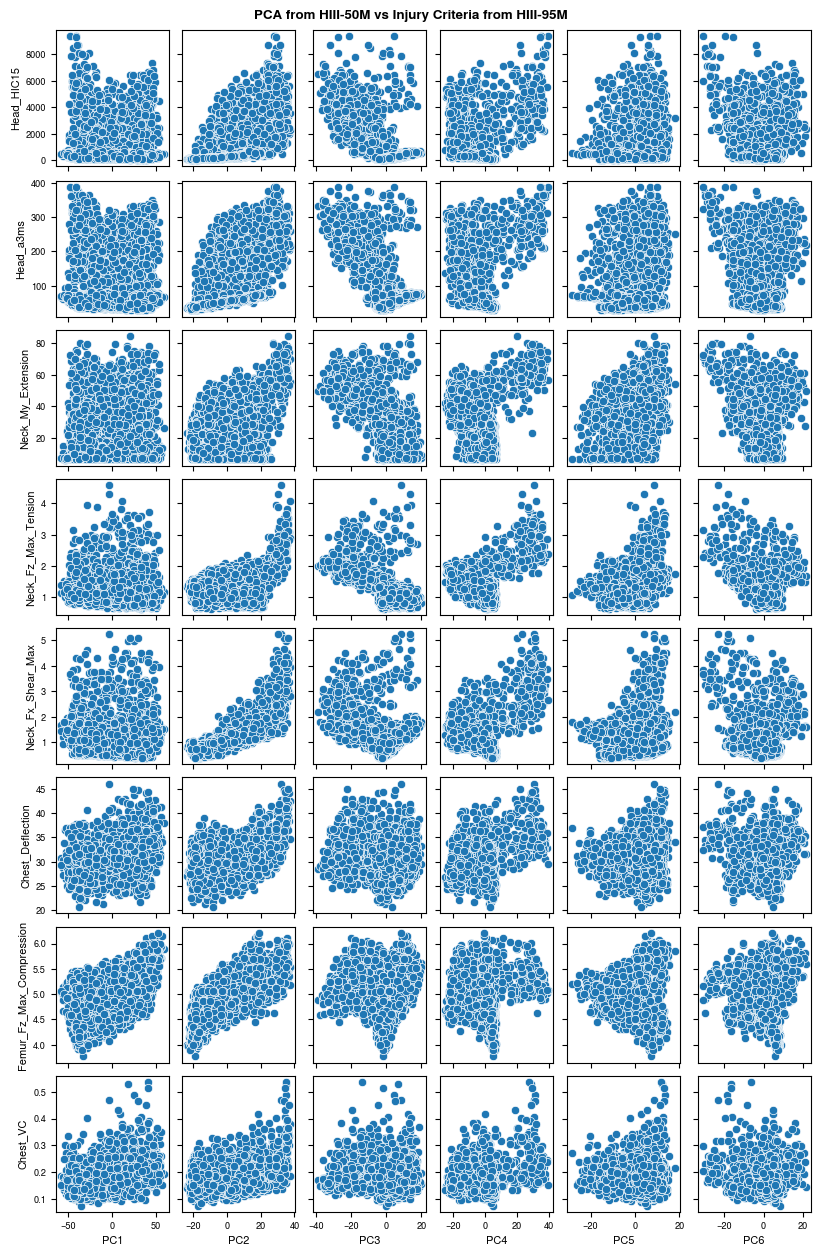

In [12]:
def experiments_7(columns: List[str], new_n_tsps: int = 140, sobol_m_max: int = 13, target_perc:int=50) -> None:
    n_max = 2**sobol_m_max

    if target_perc != 50:
        dropped_ids = json_util.load(f_path=D_DIR / STR.fname_dropped_ids)
        dropped_ids = list(set(dropped_ids["50"] + dropped_ids[str(target_perc)]))
    else:
        dropped_ids = DROP_IDS

    LOG.info("Read Channel Data")
    db_channel = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == target_perc)
            .filter(~pl.col(STR.id).is_in(dropped_ids))
            .filter(pl.col(STR.id) < n_max)
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data channel shape: %s", db_channel.shape)

    LOG.info("Read Injury Data")
    db_inj = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_injury_crit)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(dropped_ids))
            .filter(pl.col(STR.id) < n_max)
            .select(
                [
                    "Head_HIC15",
                    "Head_a3ms",
                    "Neck_My_Extension",
                    "Neck_Fz_Max_Tension",
                    "Neck_Fx_Shear_Max",
                    "Chest_Deflection",
                    "Femur_Fz_Max_Compression",
                    "Chest_VC",
                ]
                + [pl.col(STR.id).cast(pl.Int32)]
            )
            .collect()
        )
        .to_pandas()
        .set_index([STR.id])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data Injury shape: %s", db_inj.shape)

    LOG.info("Resample Data")
    db_channel = get_temporal_resampled(db_in=db_channel, new_n_tsps=new_n_tsps)
    LOG.info("Data shape after resample: %s", db_channel.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db_channel.copy()
    db_scal.loc[:, :] = scal.fit_transform(db_channel)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.95, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    # correlation
    LOG.info("Correlation")
    n_pcs = 6
    fig, ax = plt.subplots(
        ncols=n_pcs,
        nrows=db_inj.shape[1],
        figsize=(1.3*WIDTH, 2 * WIDTH),
        layout="constrained",
        sharex="col",
        sharey="row",
    )
    for i, col in enumerate(db_inj.columns):
        for j in range(n_pcs):
            sns.scatterplot(x=db_pca[f"PC{j+1}"], y=db_inj[col], ax=ax[i, j])
    fig.suptitle(f"PCA from HIII-50M vs Injury Criteria from HIII-{target_perc:02}{'F' if target_perc == 5 else 'M'}")


for p in (5,50,95):
    experiments_7(
        columns=[
            "03CHST0000OCCUACXD",
            "03CHST0000OCCUACYD",
            "03CHST0000OCCUACZD",
            "03CHST0000OCCUDSXD",
            "03CHSTLOC0OCCUDSXD",
            "03CHSTLOC0OCCUDSYD",
            "03CHSTLOC0OCCUDSZD",
            "03FEMRLE00OCCUFOZD",
            "03FEMRRI00OCCUFOZD",
            "03HEAD0000OCCUACXD",
            "03HEAD0000OCCUACYD",
            "03HEAD0000OCCUACZD",
            "03HEADLOC0OCCUDSXD",
            "03HEADLOC0OCCUDSYD",
            "03HEADLOC0OCCUDSZD",
            "03NECKUP00OCCUFOXD",
            "03NECKUP00OCCUFOYD",
            "03NECKUP00OCCUFOZD",
            "03NECKUP00OCCUMOYD",
            "03PELV0000OCCUACXD",
            "03PELV0000OCCUACYD",
            "03PELV0000OCCUACZD",
            "03PELVLOC0OCCUDSXD",
            "03PELVLOC0OCCUDSYD",
            "03PELVLOC0OCCUDSZD",
        ],
        sobol_m_max=12,
        target_perc=p,
    )

2025-01-05 10:12:41,988     INFO  MainProcess  MainThread Read Data
2025-01-05 10:12:48,674     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2025-01-05 10:12:48,675     INFO  MainProcess  MainThread Resample Data
2025-01-05 10:12:59,331     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 140
2025-01-05 10:14:15,644     INFO  MainProcess  MainThread Data shape after resample: (1146600, 25)
2025-01-05 10:14:15,645     INFO  MainProcess  MainThread Normalize Data
2025-01-05 10:14:16,072     INFO  MainProcess  MainThread Data shape after normalization: (1146600, 25)
2025-01-05 10:14:16,073     INFO  MainProcess  MainThread PCA
2025-01-05 10:16:38,223     INFO  MainProcess  MainThread Explained Variance Ratios: ['0.518', '0.689', '0.744', '0.790', '0.815', '0.836', '0.854', '0.868', '0.881', '0.891', '0.900', '0.909', '0.916', '0.922', '0.927', '0.932', '0.935', '0.939', '0.943', '0.946', '0.949', '0.951']
2025-01-05 10:16:38,224     INFO  MainProcess  MainTh

PC1        PC2        PC3        PC4        PC5        PC6  \
ID                                                                       
0    -36.641900 -23.799004  -4.342946   5.530072   1.400885   0.465627   
1      0.141691   1.355648   4.095871   2.164120  -0.131701   4.305406   
2    -20.652541 -14.867688  -1.069058  -1.822969   3.361163   5.648680   
3     23.686542  12.174445   4.503913   0.479574   1.340488   3.311125   
4     13.653627  15.964543  10.508268  -4.275287   2.808668  -2.417939   
...         ...        ...        ...        ...        ...        ...   
8187 -35.066303   7.004914   1.341125  -1.194844   0.124756   2.340374   
8188 -20.799072   8.779569   1.619597 -12.575794   7.526202  -8.202361   
8189  19.674357 -11.837231   2.223973   2.120789  -5.907786  -5.193365   
8190 -38.551145  29.005645   7.382264  24.852523  21.566807 -18.522592   
8191  -0.571569  -2.835255   0.749159   1.357366   1.112900   3.380361   

            PC7        PC8        PC9       PC10  ...       PC13      PC14  \
ID                                                ...                        
0      2.444000  10.882766  -0.274035   1.422503  ...  -0.066394 -0.234359   
1      0.659047  -4.394650  -2.854683   0.027855  ...   0.247100  2.040423   
2      3.290799   2.911633  -0.565076   0.394632  ...  -2.352749 -0.396809   
3      0.645747  -0.947341  -4.843009   3.682620  ...   3.191265 -0.207195   
4      7.305339   3.336963  -2.399475   0.968754  ...   1.352680 -0.059661   
...         ...        ...        ...        ...  ...        ...       ...   
8187  -3.132676  -2.343572   1.378658  -2.750778  ...  -1.017274  3.018635   
8188   2.171135  -5.478552  -4.990318 -13.498201  ...   3.753214 -8.173940   
8189  -0.892625  -4.488421   0.765954  -0.520664  ...   0.797188 -1.472462   
8190 -17.951421  11.093096 -12.360418   7.720162  ...  15.796190 -1.125219   
8191   0.971890  -1.334309  -2.126893   0.227484  ...  -0.373695  2.560389   

          PC15       PC16      PC17      PC18      PC19      PC20      PC21  \
ID                                                                            
0     1.525737   0.106281  0.628846 -2.924100 -1.372966  1.163307 -0.074207   
1     1.254382  -0.868079 -0.636921  2.768905 -0.494049 -1.055996  0.068752   
2    -0.038045   0.402960  1.488635  2.467244  1.329351  1.864889  0.806195   
3     3.211286  -0.078518 -0.212432 -3.962383 -3.224005 -1.201090  0.961581   
4     0.574959   0.062962 -0.232485  0.464104 -0.859021 -0.210433  3.912449   
...        ...        ...       ...       ...       ...       ...       ...   
8187 -0.286597   0.339333  0.469863 -3.508538 -0.873184  0.099211 -1.188396   
8188  2.827886   3.790543 -0.615363 -0.375511 -0.709366  1.013617 -2.707983   
8189  0.761697  -1.605806 -0.832155  0.006649  1.866846 -0.305824  0.449608   
8190  8.415806  11.343390  1.908789  8.701404 -5.085285  1.329333 -0.683544   
8191  0.208721   0.291877  0.800536  1.982015 -0.892405  1.553575  0.787309   

           PC22  
ID               
0      1.503293  
1      1.731389  
2     -0.600645  
3      0.075750  
4     -0.943404  
...         ...  
8187   0.235006  
8188   4.434756  
8189  -1.458534  
8190 -15.012919  
8191   0.388521  

[8190 rows x 22 columns]

2025-01-05 10:16:38,238     INFO  MainProcess  MainThread Plotting
2025-01-05 10:16:38,391     INFO  MainProcess  MainThread Read Sobol experiments/models/CNN/Sobol_Size/2024-12-10-06-17-56_sobol_size_95HIII_m10
2025-01-05 10:16:38,444     INFO  MainProcess  MainThread Read Sobol experiments/models/CNN/Sobol_Size/2024-12-10-10-04-56_sobol_size_95HIII_m12
2025-01-05 10:16:38,525     INFO  MainProcess  MainThread Read Sobol experiments/models/CNN/Sobol_Size/2024-12-10-13-38-02_sobol_size_95HIII_m13
2025-01-05 10:16:38,668     INFO  MainProcess  MainThread Read Sobol experiments/models/CNN/Sobol_Size/2024-12-10-06-17-56_sobol_size_95HIII_m10
2025-01-05 10:16:38,718     INFO  MainProcess  MainThread Read Sobol experiments/models/CNN/Sobol_Size/2024-12-10-10-04-56_sobol_size_95HIII_m12
2025-01-05 10:16:38,805     INFO  MainProcess  MainThread Read Sobol experiments/models/CNN/Sobol_Size/2024-12-10-13-38-02_sobol_size_95HIII_m13
2025-01-05 10:16:38,944     INFO  MainProcess  MainThread Read 

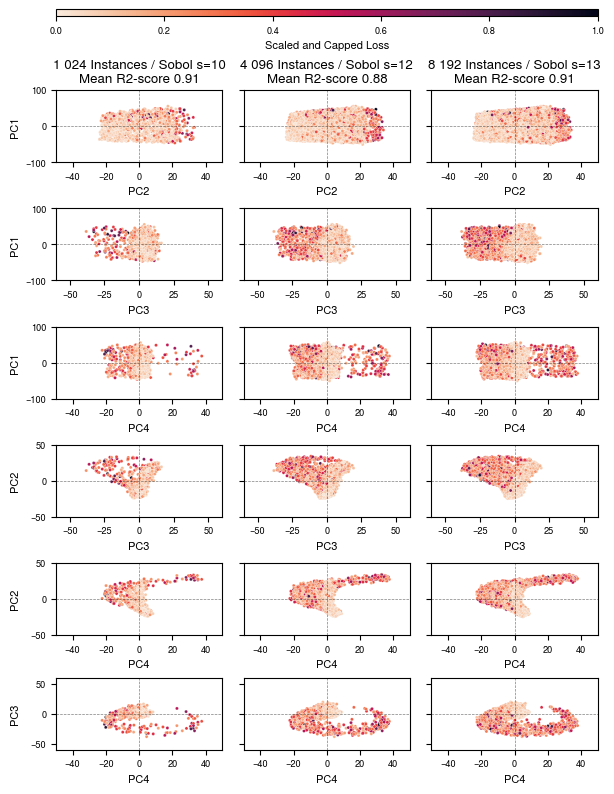

In [85]:
def experiments_3_color(
    columns: List[str], new_n_tsps: int = 140, sobol_m_max: int = 13, t_perc: int = 5, colmap="rocket_r"
) -> None:
    n_max = 2**sobol_m_max

    r2s = {13:np.mean([0.9312946241116365,0.9358516156746464,0.7527020761027856,0.9270223810839376,0.92898952264909,0.9332370962577355,0.9247918041469305,0.8894077304048018,0.9223380746677265]),
           12:np.mean([0.9312971019282021,0.9354751242700841,0.6421028709396337,0.9256394530332676,0.9180139326704716,0.9273119322429246,0.9172423422478466,0.8322976804056184,0.9176261143867696]),
           10:np.mean([0.9224789364665802,0.9171945553320291,0.8849038423717386,0.9212145988784468,0.9155493495532451,0.9195163823843928,0.9059998636094884,0.9222407579343146,0.9105648293130951])}

    LOG.info("Read Data")
    db = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .filter(pl.col(STR.id) < n_max)
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db.shape)

    LOG.info("Resample Data")
    db = get_temporal_resampled(db_in=db, new_n_tsps=new_n_tsps)
    LOG.info("Data shape after resample: %s", db.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db.copy()
    db_scal.loc[:, :] = scal.fit_transform(db)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.95, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    display(db_pca)

    # plot
    LOG.info("Plotting")
    ms = (10, 12, 13)
    dims = [[f"{m}_{i}_{j}" for m in ms] for i, j in combinations([1, 2, 3, 4], 2)]
    fig, ax = plt.subplot_mosaic(
        [["L", "L", "L"], *dims],
        layout="constrained",
        height_ratios=[0.1, *[1] * len(dims)],
    )
    cutoff = 1
    norm = plt.Normalize(0, cutoff)
    sm = plt.cm.ScalarMappable(cmap=colmap, norm=norm)
    sm.set_array([])
    plt.colorbar(mappable=sm, cax=ax["L"], orientation="horizontal")
    ax["L"].set_xlabel("Scaled and Capped Loss")
    #ax["L"].set_xticks(np.linspace(0, 1, 5))

    no_label = []
    for row in dims:
        for i, _ in enumerate(row):
            if i != 0:
                no_label.append(row[i])
    no_label = set(no_label)

    for sub in sum(dims, []):
        ax[sub].axhline(0, c="black", ls="--", lw=0.5, alpha=0.5)
        ax[sub].axvline(0, c="black", ls="--", lw=0.5, alpha=0.5)

        m, pc_y, pc_x = sub.split("_")
        # f_ = db_pca.loc[: 2 ** int(m)].copy()
        sobol_path = list(EXP_DIR.glob(f"2024-12-*-*-*-*_sobol_size_{t_perc:02d}HIII_m{m}"))[0]
        LOG.info("Read Sobol %s", sobol_path)
        sample_score = pd.read_parquet(sobol_path / "sample_score.parquet").mean(axis=1)
        shared_idx = sorted(set(sample_score.index) & set(db_pca.index))

        sample_score.where(sample_score < cutoff, cutoff, inplace=True)
        sns.scatterplot(
            data=db_pca.loc[shared_idx].copy(),
            x=f"PC{pc_x}",
            y=f"PC{pc_y}",
            ax=ax[sub],
            s=5,
            hue=sample_score.loc[shared_idx],
            # hue_norm=norm,
            palette=colmap,
        )
        ax[sub].get_legend().remove()

        if sub in dims[0]:
            ax[sub].set_title(f"{2**int(m):,} Instances / Sobol s={m}".replace(",", " ") + f"\nMean R2-score {r2s[int(m)]:.2f}")

        if sub in no_label:
            ax[sub].set_yticklabels([])
            ax[sub].set_ylabel("")

        lims = {"1": [-100, 100], "2": [-50, 50], "3": [-60, 60], "4": [-50, 50]}
        ax[sub].set_xlim(lims[pc_x])
        ax[sub].set_ylim(lims[pc_y])

    # for i in [1,2,3]:
    #    ax[f"L{i}"].axis("off")
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * WIDTH)
    LOG.info("Plotting done")
    fig.savefig(FIG_DIR / "pca_sobol.pdf")


experiments_3_color(
    columns=[
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03CHST0000OCCUDSXD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03FEMRLE00OCCUFOZD",
        "03FEMRRI00OCCUFOZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOYD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
    ],
    sobol_m_max=13,
    t_perc=95,
)

2025-01-05 10:06:15,781     INFO  MainProcess  MainThread Read Data


2025-01-05 10:06:26,047     INFO  MainProcess  MainThread Data shape: (11474190, 25)
2025-01-05 10:06:26,048     INFO  MainProcess  MainThread Resample Data
2025-01-05 10:06:39,585     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 140
2025-01-05 10:08:30,163     INFO  MainProcess  MainThread Data shape after resample: (1146600, 25)
2025-01-05 10:08:30,164     INFO  MainProcess  MainThread Normalize Data
2025-01-05 10:08:30,694     INFO  MainProcess  MainThread Data shape after normalization: (1146600, 25)
2025-01-05 10:08:30,695     INFO  MainProcess  MainThread PCA
2025-01-05 10:09:38,912     INFO  MainProcess  MainThread Explained Variance Ratios: ['0.518', '0.689', '0.744', '0.790', '0.815', '0.836', '0.854', '0.868', '0.881', '0.891', '0.900', '0.909', '0.916', '0.922', '0.927', '0.932', '0.935', '0.939', '0.943', '0.946', '0.949', '0.951']
2025-01-05 10:09:38,913     INFO  MainProcess  MainThread Data shape after PCA: (8190, 22)


PC1        PC2        PC3        PC4        PC5        PC6  \
ID                                                                       
0    -36.641900 -23.799004  -4.342946   5.530072   1.400885   0.465627   
1      0.141691   1.355648   4.095871   2.164120  -0.131701   4.305406   
2    -20.652541 -14.867688  -1.069058  -1.822969   3.361163   5.648680   
3     23.686542  12.174445   4.503913   0.479574   1.340488   3.311125   
4     13.653627  15.964543  10.508268  -4.275287   2.808668  -2.417939   
...         ...        ...        ...        ...        ...        ...   
8187 -35.066303   7.004914   1.341125  -1.194844   0.124756   2.340374   
8188 -20.799072   8.779569   1.619597 -12.575794   7.526202  -8.202361   
8189  19.674357 -11.837231   2.223973   2.120789  -5.907786  -5.193365   
8190 -38.551145  29.005645   7.382264  24.852523  21.566807 -18.522592   
8191  -0.571569  -2.835255   0.749159   1.357366   1.112900   3.380361   

            PC7        PC8        PC9       PC10  ...       PC13      PC14  \
ID                                                ...                        
0      2.444000  10.882766  -0.274035   1.422503  ...  -0.066394 -0.234359   
1      0.659047  -4.394650  -2.854683   0.027855  ...   0.247100  2.040423   
2      3.290799   2.911633  -0.565076   0.394632  ...  -2.352749 -0.396809   
3      0.645747  -0.947341  -4.843009   3.682620  ...   3.191265 -0.207195   
4      7.305339   3.336963  -2.399475   0.968754  ...   1.352680 -0.059661   
...         ...        ...        ...        ...  ...        ...       ...   
8187  -3.132676  -2.343572   1.378658  -2.750778  ...  -1.017274  3.018635   
8188   2.171135  -5.478552  -4.990318 -13.498201  ...   3.753214 -8.173940   
8189  -0.892625  -4.488421   0.765954  -0.520664  ...   0.797188 -1.472462   
8190 -17.951421  11.093096 -12.360418   7.720162  ...  15.796190 -1.125219   
8191   0.971890  -1.334309  -2.126893   0.227484  ...  -0.373695  2.560389   

          PC15       PC16      PC17      PC18      PC19      PC20      PC21  \
ID                                                                            
0     1.525737   0.106281  0.628846 -2.924100 -1.372966  1.163307 -0.074207   
1     1.254382  -0.868079 -0.636921  2.768905 -0.494049 -1.055996  0.068752   
2    -0.038045   0.402960  1.488635  2.467244  1.329351  1.864889  0.806195   
3     3.211286  -0.078518 -0.212432 -3.962383 -3.224005 -1.201090  0.961581   
4     0.574959   0.062962 -0.232485  0.464104 -0.859021 -0.210433  3.912449   
...        ...        ...       ...       ...       ...       ...       ...   
8187 -0.286597   0.339333  0.469863 -3.508538 -0.873184  0.099211 -1.188396   
8188  2.827886   3.790543 -0.615363 -0.375511 -0.709366  1.013617 -2.707983   
8189  0.761697  -1.605806 -0.832155  0.006649  1.866846 -0.305824  0.449608   
8190  8.415806  11.343390  1.908789  8.701404 -5.085285  1.329333 -0.683544   
8191  0.208721   0.291877  0.800536  1.982015 -0.892405  1.553575  0.787309   

           PC22  
ID               
0      1.503293  
1      1.731389  
2     -0.600645  
3      0.075750  
4     -0.943404  
...         ...  
8187   0.235006  
8188   4.434756  
8189  -1.458534  
8190 -15.012919  
8191   0.388521  

[8190 rows x 22 columns]

2025-01-05 10:09:38,930     INFO  MainProcess  MainThread Plotting
2025-01-05 10:09:40,832     INFO  MainProcess  MainThread Plotting done
2025-01-05 10:09:45,180     INFO  MainProcess  MainThread maxp pruned
2025-01-05 10:09:45,184     INFO  MainProcess  MainThread cmap pruned
2025-01-05 10:09:45,185     INFO  MainProcess  MainThread post pruned
2025-01-05 10:09:45,187     INFO  MainProcess  MainThread CFF  pruned
2025-01-05 10:09:45,189     INFO  MainProcess  MainThread GPOS pruned
2025-01-05 10:09:45,195     INFO  MainProcess  MainThread GSUB pruned
2025-01-05 10:09:45,197     INFO  MainProcess  MainThread Added .notdef to subset
2025-01-05 10:09:45,197     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 32 glyphs before
2025-01-05 10:09:45,198     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'C', 'I', 'L', 'M', 'P', 'R', 'S', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'hyphen', 'l', 'minus', 'n', 'nine', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space',

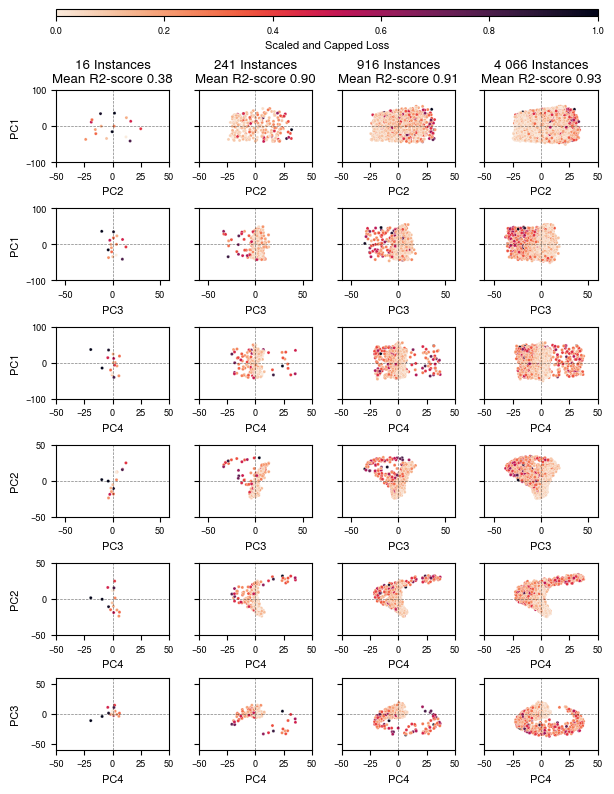

In [84]:
def experiments_3_color_adapt(columns: List[str], new_n_tsps: int = 140, sobol_m_max: int = 13, colmap="rocket_r") -> None:
    n_max = 2**sobol_m_max

    b_path = Path("experiments") / "models" / "CNN" / "AdaptiveDOE" / "2024-12-27-18-53-00_knn_sampler_AnnUniversal_perc95"
    b_path = Path("experiments")/"2025-01-03-11-10-00_knn_sampler_AnnUniversal_perc95"
    paths = {10: b_path / "iteration_0", 11: b_path / "iteration_1", 13: b_path / "iteration_18", 12: b_path / "iteration_4"}
    r2s = {num: pd.read_csv(ppath / "results.csv", index_col=[0, 1]).loc[(-1, "Test"), :].mean() for num, ppath in paths.items()}
    LOG.info("Read Data")
    db = (
        (
            pl.scan_parquet(source=D_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == 50)
            .filter(~pl.col(STR.id).is_in(DROP_IDS))
            .filter(pl.col(STR.id) < n_max)
            .select(columns + [STR.time, pl.col(STR.id).cast(pl.Int32)])
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
        .apply(pd.to_numeric, downcast="float")
    )
    LOG.info("Data shape: %s", db.shape)

    LOG.info("Resample Data")
    db = get_temporal_resampled(db_in=db, new_n_tsps=new_n_tsps)
    LOG.info("Data shape after resample: %s", db.shape)

    LOG.info("Normalize Data")
    scal = StandardScaler()
    db_scal = db.copy()
    db_scal.loc[:, :] = scal.fit_transform(db)
    LOG.info("Data shape after normalization: %s", db_scal.shape)

    LOG.info("PCA")
    pca = PCA(n_components=0.95, svd_solver="full")
    tmp = db_scal.unstack(level=STR.time)
    db_pca = pd.DataFrame(pca.fit_transform(tmp), columns=[f"PC{i+1}" for i in range(pca.n_components_)], index=tmp.index)
    LOG.info("Explained Variance Ratios: %s", [f"{x:.3f}" for x in np.cumsum(pca.explained_variance_ratio_)])
    LOG.info("Data shape after PCA: %s", db_pca.shape)

    display(db_pca)

    # plot
    LOG.info("Plotting")
    ms = (10,11, 12, 13)
    dims = [[f"{m}_{i}_{j}" for m in ms] for i, j in combinations([1, 2, 3, 4], 2)]
    fig, ax = plt.subplot_mosaic(
        [["L"]*len(ms), *dims],
        layout="constrained",
        height_ratios=[0.1, *[1] * len(dims)],
    )
    cutoff = 1
    norm = plt.Normalize(0, cutoff)
    sm = plt.cm.ScalarMappable(cmap=colmap, norm=norm)
    sm.set_array([])
    plt.colorbar(mappable=sm, cax=ax["L"], orientation="horizontal")
    ax["L"].set_xlabel("Scaled and Capped Loss")
    # ax["L"].set_xticks(np.linspace(0, 1, 5))

    no_label = []
    for row in dims:
        for i, _ in enumerate(row):
            if i != 0:
                no_label.append(row[i])
    no_label = set(no_label)

    for sub in sum(dims, []):
        ax[sub].axhline(0, c="black", ls="--", lw=0.5, alpha=0.5)
        ax[sub].axvline(0, c="black", ls="--", lw=0.5, alpha=0.5)

        m, pc_y, pc_x = sub.split("_")
        sample_score = pd.read_parquet(paths[int(m)] / "sample_score.parquet").mean(axis=1)
        shared_idx = sorted(set(sample_score.index) & set(db_pca.index))

        sample_score.where(sample_score < cutoff, cutoff, inplace=True)
        sns.scatterplot(
            data=db_pca.loc[shared_idx].copy(),
            x=f"PC{pc_x}",
            y=f"PC{pc_y}",
            ax=ax[sub],
            s=5,
            hue=sample_score.loc[shared_idx],
            # hue_norm=norm,
            palette=colmap,
        )
        ax[sub].get_legend().remove()

        if sub in dims[0]:
            ax[sub].set_title(f"{sample_score.shape[0]:,} Instances".replace(",", " ") + f"\nMean R2-score {r2s[int(m)]:.2f}")

        if sub in no_label:
            ax[sub].set_yticklabels([])
            ax[sub].set_ylabel("")

        lims = {"1": [-100, 100], "2": [-50, 50], "3": [-60, 60], "4": [-50, 50]}
        ax[sub].set_xlim(lims[pc_x])
        ax[sub].set_ylim(lims[pc_y])

    # for i in [1,2,3]:
    #    ax[f"L{i}"].axis("off")
    fig.align_ylabels(list(ax.values()))
    fig.set_figwidth(WIDTH)
    fig.set_figheight(1.3 * WIDTH)
    LOG.info("Plotting done")
    fig.savefig(FIG_DIR / "pca_sobol_adapt.pdf")


experiments_3_color_adapt(
    columns=[
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03CHST0000OCCUDSXD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03FEMRLE00OCCUFOZD",
        "03FEMRRI00OCCUFOZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOYD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
    ],
    sobol_m_max=13,
)